In [30]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from mip import CutType
from model.model import BSS
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
try:
    data_set = get_data_json("../../data/ReggioEmilia/4ReggioEmilia30.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 1
    Q = vehicle_capacity
    q = demands
    c = distance_matrix

    problem = BSS(V, A, m, Q, q, c)
except Exception as e:
    raise e

2024-09-03 09:54:57.953 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


In [32]:
df = pd.DataFrame(problem.c)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,3700,4000,3900,4900,3900,4800,3800,4000,2600,4600,3800,3000,3500
1,4300,0,1300,300,2400,1200,1300,2600,1600,1200,1000,600,1400,800
2,4500,900,0,900,2100,900,1000,1900,1300,2100,700,1400,2200,500
3,4500,300,1300,0,2200,1200,1000,2500,1600,1500,700,800,1600,800
4,5500,2200,2600,2000,0,3100,1200,3600,3200,2500,1800,2000,2600,2700
5,3700,800,900,1100,2900,0,1800,1500,500,2000,1500,1300,1700,400
6,5300,1400,1800,1100,2000,2300,0,2700,2300,2200,900,1800,2400,1900
7,3500,2200,1700,2400,3600,1500,2400,0,1400,3000,2400,2600,2700,1800
8,4300,800,1100,1000,3100,1000,2000,1500,0,1600,1700,1200,1300,600
9,3300,1600,2600,1800,2300,2500,2200,3000,2700,0,2100,1200,800,2100


In [33]:
problem.t = [problem.model.add_var(name=f"t_{j}", var_type=mip.CONTINUOUS) for j in V]

In [34]:
for j in V:
    problem.model += problem.t[j] >= max(0, q[j])
    problem.model += problem.t[j] <= min(Q, Q + q[j])

for i in V:
    for j in V:
        if j != 0 and i != j:
            M = 100000
            problem.model += problem.t[j] >= problem.t[i] + q[j] - M * (
                1 - problem.x[i][j]
            )

for i in V:
    for j in V:
        if i != 0 and i != j:
            M = 100000
            problem.model += problem.t[i] >= problem.t[j] - q[j] - M * (
                1 - problem.x[i][j]
            )

In [35]:
new_constraints_added = True
while new_constraints_added:
    problem.model.optimize(relax=True)

    print(
        "Status: {} Objective Value: {}".format(
            problem.model.status, problem.model.objective_value
        )
    )

    graph = nx.DiGraph()

    for vertice in V:
        graph.add_node(vertice)

    for source, target in A:
        if source != target and problem.x[source][target].x > 1e-6:
            graph.add_edge(source, target, capacity=problem.x[source][target].x)

    new_constraints_added = False

    for node in list(graph.nodes()):
        if node != 0:
            flow_value, _ = nx.maximum_flow(graph, 0, node)
            if flow_value < 1:
                cut_value, (S, NS) = nx.minimum_cut(graph, 0, node)
                if cut_value <= 0.99 and 0 not in S and len(S) != 0:
                    problem.model += (
                        mip.xsum(problem.x[i][j] for i in S for j in S) <= len(S) - 1
                    )
                    new_constraints_added = True

    if not new_constraints_added and problem.model.solver_name.lower() == "cbc":
        cut_pool = problem.model.generate_cuts(
            [
                CutType.GOMORY,
                CutType.MIR,
                CutType.ZERO_HALF,
                CutType.KNAPSACK_COVER,
            ]
        )

        if cut_pool.cuts:
            problem.model += cut_pool
            new_constraints_added = True

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 338 (-59) rows, 169 (-41) columns and 1248 (-212) elements
Clp1000I sum of infeasibilities 0.761715 - average 0.0022536, 127 fixed columns
Coin0506I Presolve 47 (-291) rows, 18 (-151) columns and 133 (-1115) elements
Clp0006I 0  Obj 17500.083 Primal inf 0.1263853 (10) Dual inf 5.7800373e+13 (15)
Clp0029I End of values pass after 18 iterations
Clp0014I Perturbing problem by 0.001% of 135.53954 - largest nonzero change 2.7998878e-05 ( 0.0019264453%) - largest zero change 1.1053411e-05
Clp0000I Optimal - objective value 17500.087
Clp0000I Optimal - objective value 17500.087
Coin0511I After Postsolve, objective 17500.087, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 17500.087 Dual inf 15266.667 (32)
Clp0014I Perturbing problem by 0.001% of 0.97298029 - largest nonzero change 2.001598e-05 ( 0.001000799%) - largest zero change 2.9901009e-05
Clp0000I Optimal - objective value 

In [36]:
if problem.model.num_solutions:
    selected_edges = [
        (origin, destination)
        for origin in V
        for destination in V
        if 0.5 <= problem.x[origin][destination].x
        and problem.x[origin][destination].x <= 1
    ]

    remaining_bikes = [problem.t[station].x for station in range(len(problem.t))]

    for origin, destination in selected_edges:
        edge_variable = problem.model.var_by_name(f"x_{origin}_{destination}")
        edge_value = problem.x[origin][destination].x
        print(f"{edge_variable} = {edge_value}")

x_0_9 = 0.9999999999999999
x_1_3 = 0.9999999999999999
x_3_1 = 0.99999
x_4_6 = 0.9999533333333335
x_6_10 = 0.9999433333333331
x_7_5 = 0.99997
x_9_11 = 0.99996
x_10_4 = 0.9999433333333336
x_11_12 = 0.99996
x_12_0 = 0.9999999999999999
x_12_9 = 0.99996
x_13_2 = 0.99997


In [37]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -3
Station 2: 1
Station 3: 2
Station 4: -5
Station 5: 2
Station 6: -10
Station 7: -2
Station 8: -2
Station 9: 3
Station 10: -1
Station 11: -6
Station 12: -9
Station 13: 2


In [38]:
for station, balance in enumerate(remaining_bikes):
    print(f"Station {station} remaining bikes after visit: {balance}")

Station 0 remaining bikes after visit: 0.0
Station 1 remaining bikes after visit: 0.9999699999896358
Station 2 remaining bikes after visit: 0.9999999999999999
Station 3 remaining bikes after visit: 2.999969999997449
Station 4 remaining bikes after visit: 15.66534999996893
Station 5 remaining bikes after visit: 4.0000000000156275
Station 6 remaining bikes after visit: 10.33201666664176
Station 7 remaining bikes after visit: 0.0
Station 8 remaining bikes after visit: 2.0000000000078137
Station 9 remaining bikes after visit: 14.99903999999835
Station 10 remaining bikes after visit: 14.99868333332962
Station 11 remaining bikes after visit: 12.999040000008515
Station 12 remaining bikes after visit: 7.999039999988979
Station 13 remaining bikes after visit: 3.000000000011721


In [39]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{problem.c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

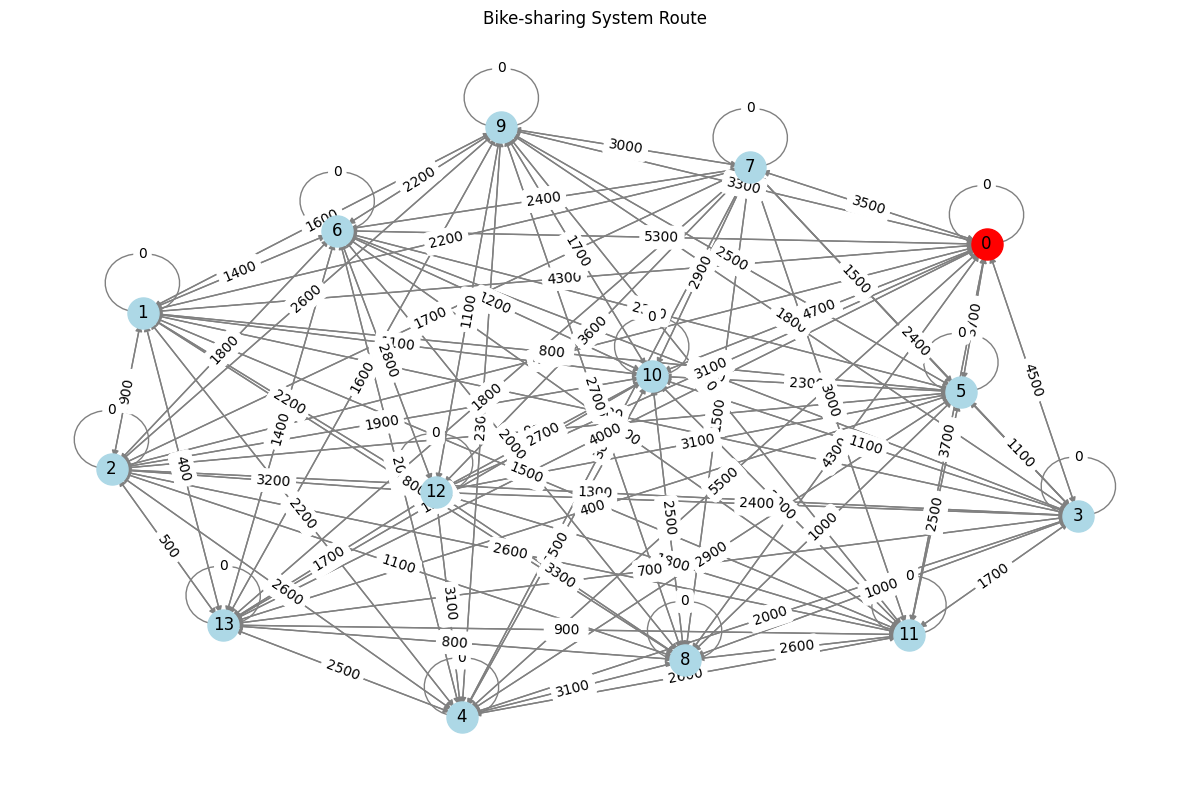

In [40]:
plot_route(V, A)

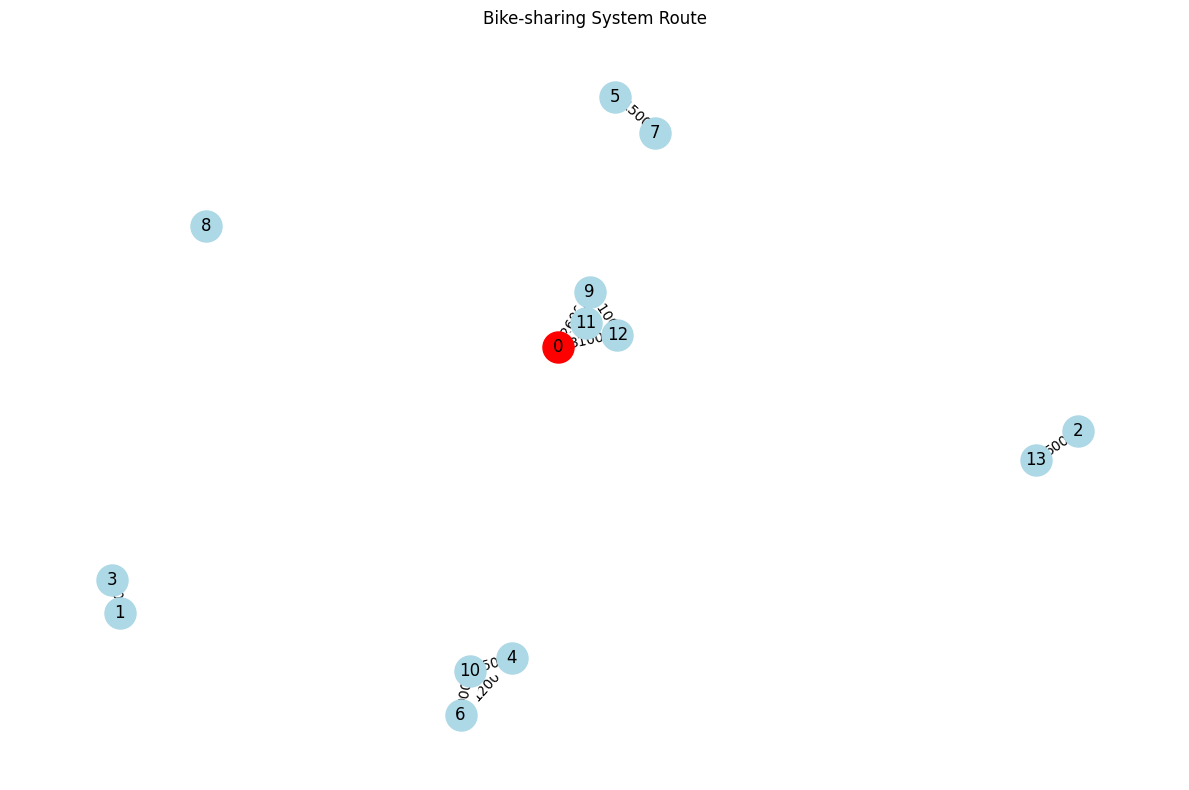

In [41]:
plot_route(V, selected_edges)